## Project for DL for CV. Part 1. Preparation.
#### Author: `Sofiia Kononovych`

In this lab I am going to begin working on my project perform EDA of the Intel Image Classification DataSet

Overall we have 24 345 images, 14 044 images in train folder, 3000 in test folder and 7301 in pred folder.

#### Load and explore the data

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from torchvision import datasets, transforms
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
import random
from collections import Counter
import seaborn as sns
import torchvision.transforms as T

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Structure of my Intel Image Dataset folder

```
intel-image-cls/
├── seg_train/        # Training set (with class subfolders)
│   ├── buildings/
│   ├── forest/
│   ├── glacier/
│   ├── mountain/
│   ├── sea/
│   └── street/
│
├── seg_test/         # Test set (with class subfolders)
│   ├── buildings/
│   ├── forest/
│   ├── glacier/
│   ├── mountain/
│   ├── sea/
│   └── street/
│
└── seg_pred/         # Unlabeled images for prediction/inference
    ├── img1.jpg
    ├── img2.jpg
    └── ...
```



In [56]:
base_path = '/content/drive/MyDrive/intel-image-cls'
train_dir = os.path.join(base_path, 'seg_train')
test_dir = os.path.join(base_path, 'seg_test')
pred_dir = os.path.join(base_path, 'seg_pred')

Count number of classes

In [57]:
classes = sorted(os.listdir(train_dir))
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

Number of classes: 6
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Check image format

In [58]:
sample_path = os.path.join(train_dir, classes[0], os.listdir(os.path.join(train_dir, classes[0]))[0])
img = Image.open(sample_path)
print(f"Image size: {img.size}, mode: {img.mode}")

Image size: (150, 150), mode: RGB


Check for balanced data in each class

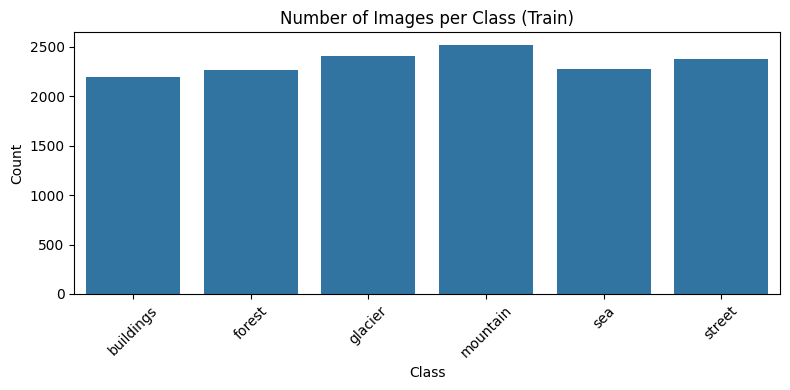

In [59]:
# Fast count: number of files per class in seg_train
class_counts = {
    cls: len(os.listdir(os.path.join(train_dir, cls)))
    for cls in sorted(os.listdir(train_dir))
}

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Number of Images per Class (Train)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the plot above we can see thatthe dataset seems to be relatevely balanced

Visualize 3 Random Images Per Class

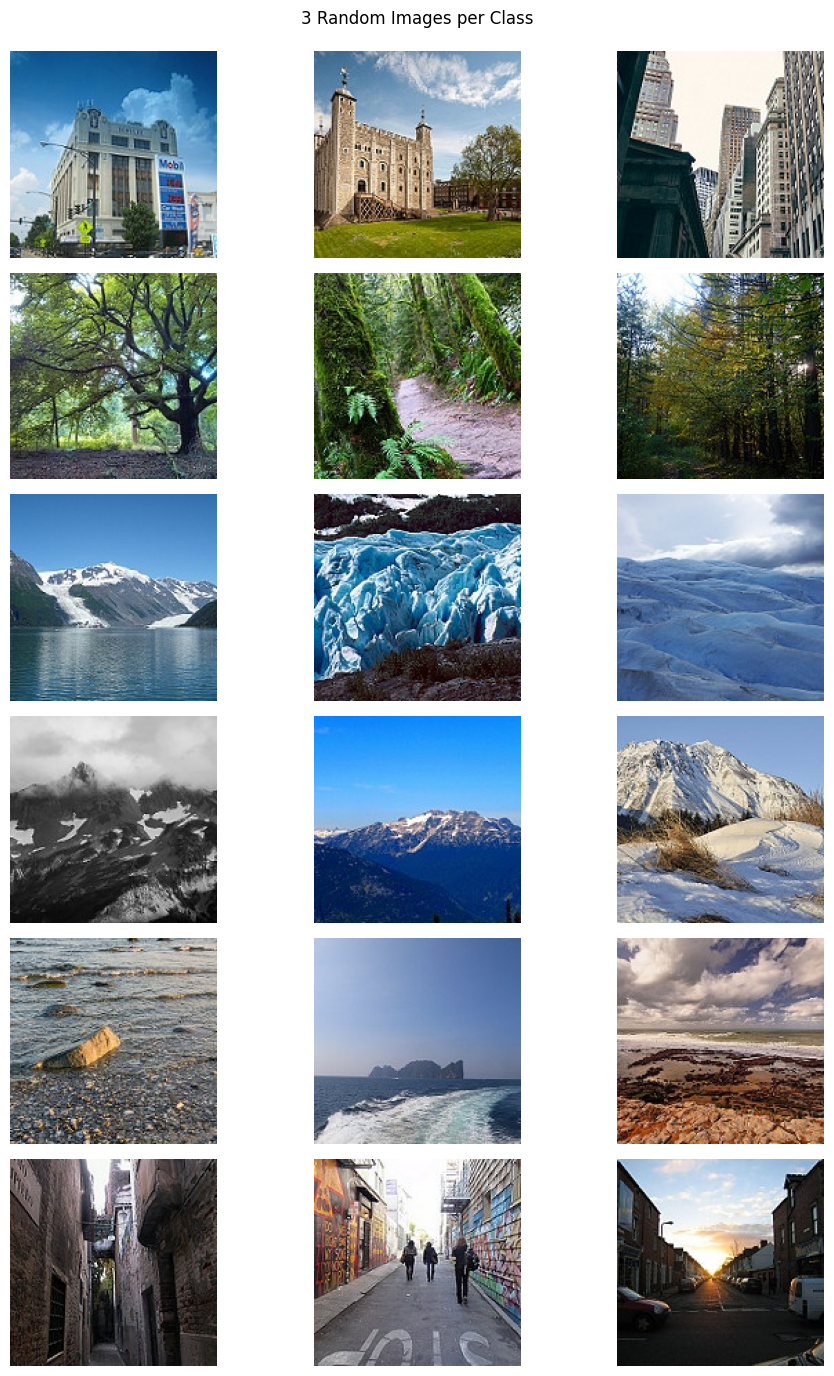

In [60]:
fig, axes = plt.subplots(nrows=len(classes), ncols=3, figsize=(10, 14))
fig.suptitle("3 Random Images per Class")

for i, cls in enumerate(classes):
    class_folder = os.path.join(train_dir, cls)
    sample_imgs = random.sample(os.listdir(class_folder), 3)
    for j, img_name in enumerate(sample_imgs):
        img_path = os.path.join(class_folder, img_name)
        img = Image.open(img_path).convert("RGB")
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_ylabel(cls, rotation=0, size='large', labelpad=40)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

####Turning raw images into datasets

In [61]:
full_train_dataset = datasets.ImageFolder(train_dir)

Find out the length of train set

In [62]:
len(full_train_dataset)

14044

Split on test and validation

In [63]:
# Split into train/val
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

#### Tensor transformation (+ normalizing)

In [81]:
# Define separate transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(150, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],       # this normalisation may be more effective than classic one with 0.5
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

I think that later it is worth exploring different augmentation techniques on our dataset like these below and check their efficiency

In [65]:
#train_ transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(20),
#     # transforms.RandomCrop(32, padding=2),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

Apply transforms after splitting


In [83]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

Load and transform test dataset too

In [67]:
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

Special handling of unlabeled data

In [68]:
class UnlabeledImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [69]:
pred_dataset = UnlabeledImageDataset(pred_dir, transform=val_transform)

Check the length of each dataset

In [70]:
# Summary
print(f"Train dataset: {len(train_dataset)}")
print(f"Val dataset:   {len(val_dataset)}")
print(f"Test dataset:  {len(test_dataset)}")
print(f"Pred dataset:  {len(pred_dataset)}")

Train dataset: 11236
Val dataset:   2808
Test dataset:  3000
Pred dataset:  7301


#### Create DataLoaders

batch size = 32

In [84]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [72]:
class_names = train_dataset.dataset.classes
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Check if batch shape and labels correctly set

In [85]:
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)
print("Label indices:", labels)

Batch shape: torch.Size([32, 3, 150, 150])
Label indices: tensor([0, 4, 2, 0, 1, 2, 4, 3, 0, 3, 4, 4, 2, 3, 0, 0, 0, 4, 3, 0, 2, 4, 5, 0,
        4, 2, 4, 2, 4, 2, 3, 3])


Visualise one batch from DataLoader


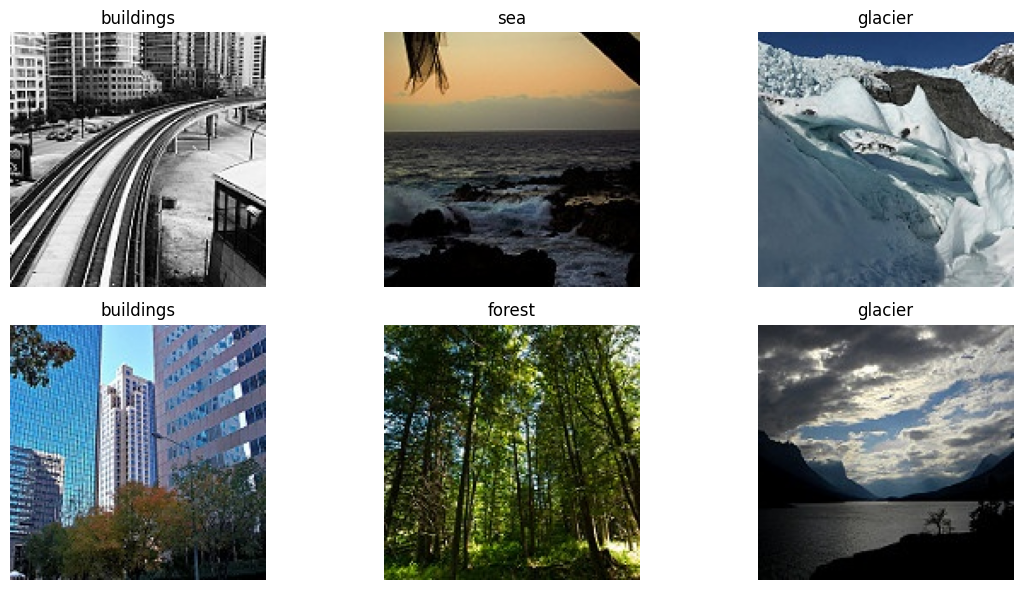

In [86]:
plt.figure(figsize=(12, 6))
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

for i in range(6):
    img = images[i] * std + mean               # Denormalize
    img = img.permute(1, 2, 0).clamp(0, 1)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()

Comparison of original images vs augmented

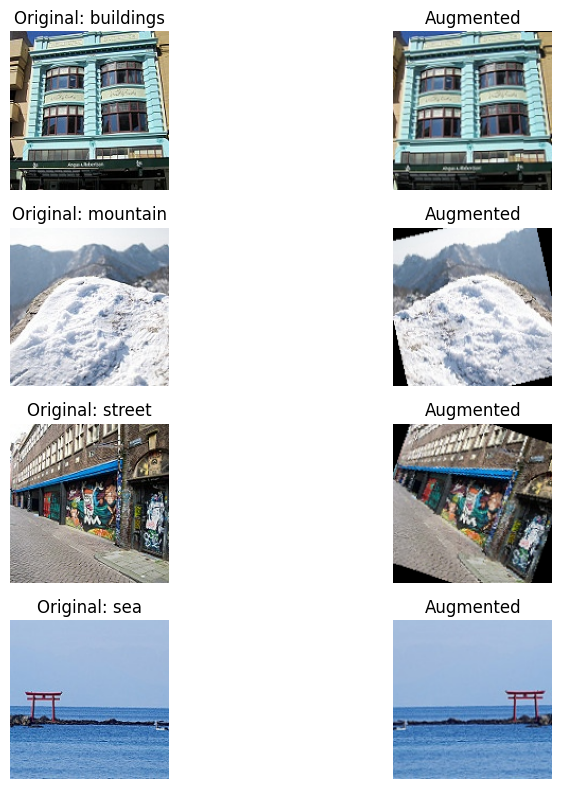

In [87]:
# Original dataset
raw_dataset = ImageFolder(train_dir)
class_names = raw_dataset.classes

sample_i = random.sample(range(len(raw_dataset)), 4)

original_transform = T.Compose([
    T.ToTensor()
])

augmented_transform = train_transform

# Plot together
plt.figure(figsize=(10, 8))
for i, idx in enumerate(sample_i):
    image, label = raw_dataset[idx]

    orig_img = original_transform(image)
    aug_img = augmented_transform(image)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    aug_img = aug_img * std + mean

    orig_img = orig_img.permute(1, 2, 0).clamp(0, 1)
    aug_img = aug_img.permute(1, 2, 0).clamp(0, 1)

    # Plot original
    plt.subplot(len(sample_i), 2, 2 * i + 1)
    plt.imshow(orig_img)
    plt.title(f"Original: {class_names[label]}")
    plt.axis('off')

    # Plot augmented
    plt.subplot(len(sample_i), 2, 2 * i + 2)
    plt.imshow(aug_img)
    plt.title("Augmented")
    plt.axis('off')

plt.tight_layout()
plt.show()


### Conclusions

- we have loaded and explored the Intel Image Classification dataset

- the data is relatavely balanced which gives us understanding how to work with it in the future (and for example we understand that accuracy is good metric here)

- transformations and data augmentation were used to improve training performance

- we also visualised few samples of each class and batch example to understand the specifications of the images and their quality

- dataLoader was created for training, validation, testing, and prediction set.

### Plan for the next steps

- try different augmentation on train

- fine-tune hyperparams (batch size, lr) if needed - also try ceclical LR


Evaluation Metrics:
- **Accuracy** — primary metric for multi-class classification.
- **F1-Score**
- **Confusion Matrix**
- **Loss (CrossEntropy)** — to monitor training performance.

Architecture of the future CNN (basic version --> later add more layers):

- 3 convolutional layers:
  - Filters: 32 -> 64 -> 128
  - Kernel size: 3x3
  - Padding = 1
  - Activation: **ReLU**

- Batch Normalisation after each convolutional layer

Pooling:
- **MaxPooling2D** (2x2) after each convolutional layer.

Fully Connected (Dense) Layers:
- `Flatten` -> `Dense(256)` -> `Dropout` -> `Dense(6)`
- **Softmax** for 6 output classes

Loss Function:
- `CrossEntropyLoss`

Optimizer:
- `Adam` (learning rate = 0.001)

Dropout:
- Dropout (0.2 - 0.5)




In [88]:
# basic model I plan to use

class BasicCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(BasicCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 18 * 18, 256)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

We will test it in next steps!